## (PSL) Local Smoother

Install two packages
- `pip install scikit-fda`
- `pip install scikit-misc`

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.ml.regression._kernel_regression import KernelRegression

from skmisc.loess import loess

### Load Data
To illustrate local regression techniques, I've chosen three distinct data sets.

The first two are simulated.

- In the first set `exa`, the true curve is smooth. Notably, on the left side, it remains relatively flat, while on the right, there's a noticeable fluctuation.

- In the second set `exb`, the true curve is a simple straight line, , but two outliers may impact the estimated curve.

The third data set is derived from observations of the Old Faithful Geyser. Familiar to many statistics courses, each data point here denotes the duration of a specific eruption, while the y-axis represents the waiting time between eruptions. There's an evident positive correlation between these two variables. While it might be tempting to fit a linear model, in this session, we will explore non-linear modeling to uncover deeper insights the data might offer.

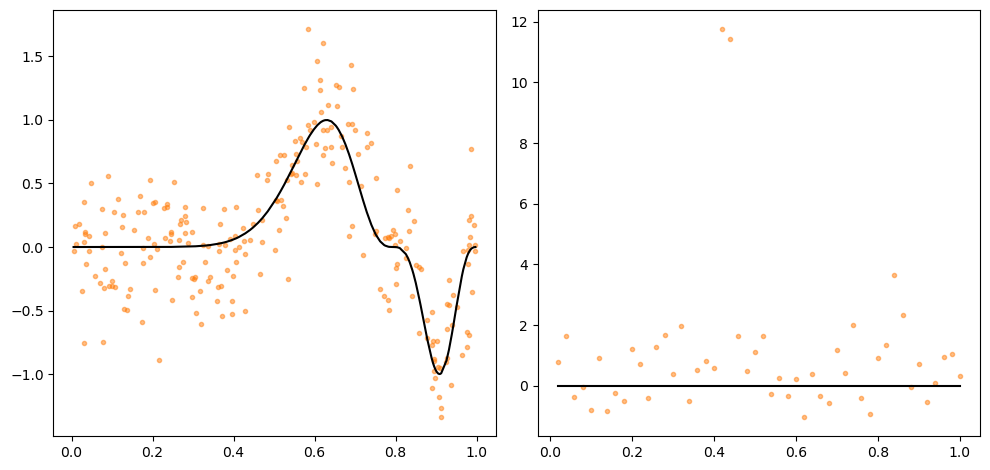

In [2]:
url = "https://liangfgithub.github.io/Data/Example_A.csv"
exa = pd.read_csv(url)

url = "https://liangfgithub.github.io/Data/Example_B.csv"
exb = pd.read_csv(url)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(exa['x'], exa['m'], c='k')
axes[0].scatter(exa['x'], exa['y'], marker='.', alpha=0.5, c='tab:orange')

axes[1].plot(exb['x'], exb['m'], c='k')
axes[1].scatter(exb['x'], exb['y'], marker='.', alpha=0.5, c='tab:orange')

fig.set_figwidth(10)
fig.tight_layout()


Text(0, 0.5, 'Waiting')

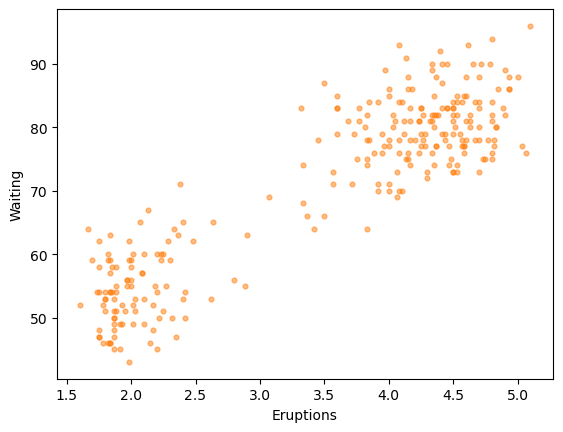

In [3]:
url = "https://liangfgithub.github.io/Data/faithful.dat"
data = pd.read_table(url, sep="\s+", index_col=0)
x = data['eruptions'].to_numpy().reshape(-1, 1)
y = data['waiting']

plt.scatter(x, y, 12, alpha=0.5, c='tab:orange')
plt.xlabel('Eruptions')
plt.ylabel('Waiting')

### Kernel Smoothing
Using the Old Faithful data as an example, we applied kernel smoothing with varying bandwidths. As the bandwidth increases, it's similar to enlarging the kernel neighbors. Consequently, the function becomes progressively flatter since we're averaging across a broader set of data points.

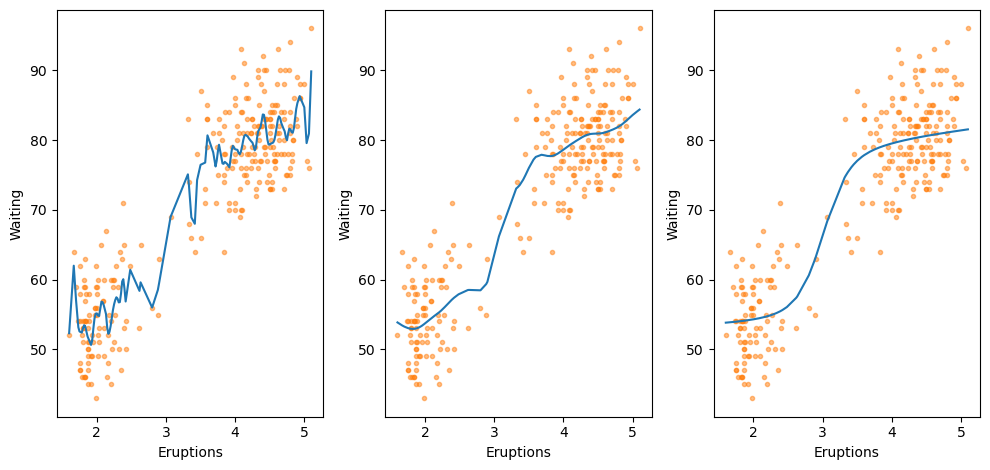

In [4]:
bws = 0.25 * np.array([0.1, 0.5, 2])

x_sort = np.sort(x, axis=0)
fig, axes = plt.subplots(nrows=1, ncols=3)
for i, bw in enumerate(bws):
    tmp_ks = KernelRegression(
        kernel_estimator=NadarayaWatsonHatMatrix(bandwidth=bw))
    tmp_ks.fit(x, y)
    y_smooth = tmp_ks.predict(x_sort)
    axes[i].plot(x_sort, y_smooth)
    axes[i].scatter(x, y, marker='.', alpha=0.5, c='tab:orange')
    axes[i].set_xlabel("Eruptions")
    axes[i].set_ylabel("Waiting")

fig.set_figwidth(10)
fig.tight_layout()

### Bandwith Selection
Use CV to select bandwidth

#### Old Faithful Data

In [5]:
# ref: https://fda.readthedocs.io/en/latest/auto_examples/plot_kernel_regression.html
bws = np.logspace(-2, 0, num=100)
nw = GridSearchCV(
    KernelRegression(kernel_estimator=NadarayaWatsonHatMatrix()),
    param_grid={'kernel_estimator__bandwidth': bws}
)

nw.fit(x, y)
print(
    'Nadaraya-Watson bandwidth:',
    nw.best_params_['kernel_estimator__bandwidth'],
)

Nadaraya-Watson bandwidth: 0.27185882427329416


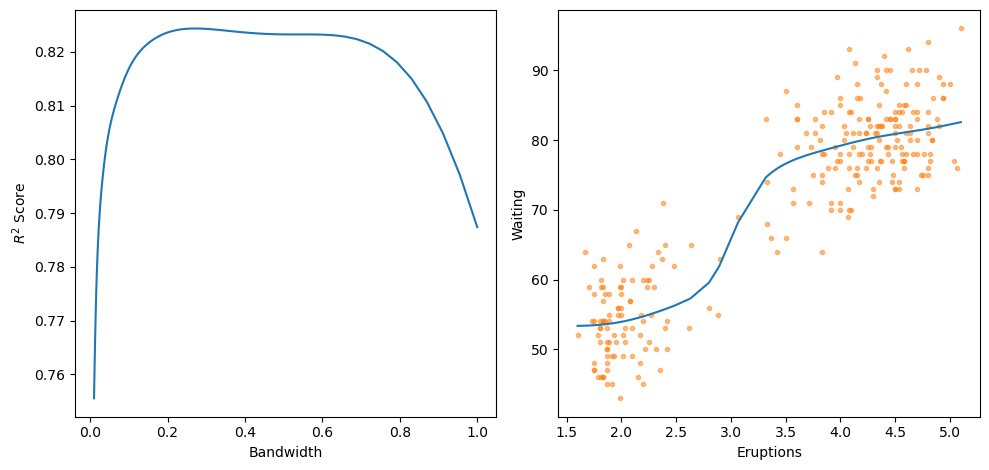

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot(bws, nw.cv_results_['mean_test_score'])
axes[0].set_xlabel("Bandwidth")
axes[0].set_ylabel("$R^2$ Score")

ks = nw.best_estimator_
y_smooth = ks.predict(x_sort)
axes[1].plot(x_sort, y_smooth)
axes[1].scatter(x, y, marker='.', alpha=0.5, c='tab:orange')
axes[1].set_xlabel("Eruptions")
axes[1].set_ylabel("Waiting")

fig.set_figwidth(10)
fig.tight_layout()

However, a word of caution: If you're crafting your own algorithm for such smoothing procedures using cross-validation, I recommend considering the one standard error principle. This approach is inherently more stable. If you strictly select based on the minimum CV error, you might find the region is relatively flat, which means different iterations of cross-validation could yield variable lambda choices within this range.

#### Simulated Data
Try conducting cross-validation on the simulated data `exa` and `exb`.

For `exb`, the example with a straightforward line containing two outliers, it might be difficult to find an optimal bandwidth. The challenge with Example B are the two outliers. For data like Example B, local regression and kernel smoothing may not be the most suitable analytical approaches.

#### LOESS

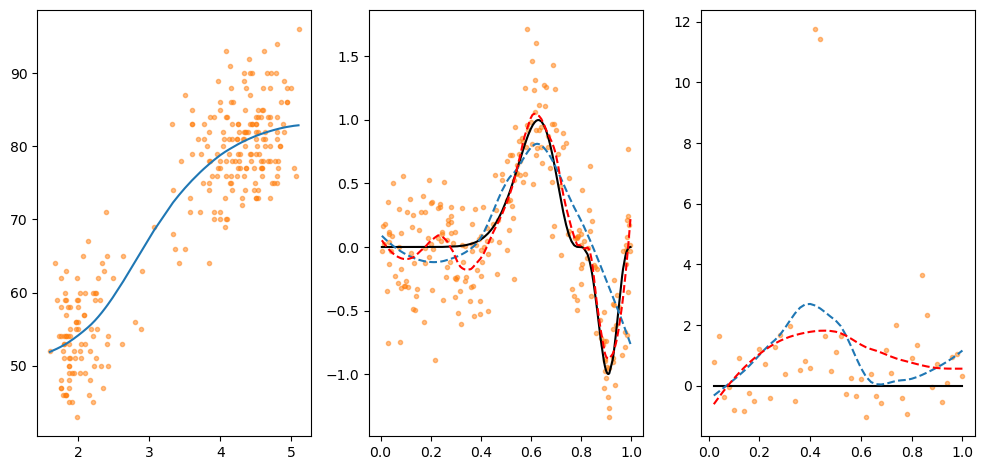

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3)

smoothed = loess(x, y).predict(x_sort).values
axes[0].plot(x_sort, smoothed)
axes[0].scatter(x, y, marker='.', alpha=0.5, c='tab:orange')

smoothed = loess(exa['x'], exa['y']).predict(exa['x']).values
smoothed2 = loess(exa['x'], exa['y'], span=0.22).predict(exa['x']).values
axes[1].plot(exa['x'], exa['m'], c='k')
axes[1].plot(exa['x'], smoothed, '--')
axes[1].plot(exa['x'], smoothed2, '--', c='r')
axes[1].scatter(exa['x'], exa['y'], marker='.', alpha=0.5, c='tab:orange')

smoothed = loess(exb['x'], exb['y']).predict(exb['x']).values
smoothed2 = loess(exb['x'], exb['y'], span=1).predict(exb['x']).values
axes[2].plot(exb['x'], exb['m'], c='k')
axes[2].plot(exb['x'], smoothed, '--')
axes[2].plot(exb['x'], smoothed2, '--', c='r')
axes[2].scatter(exb['x'], exb['y'], marker='.', alpha=0.5, c='tab:orange')

fig.set_figwidth(10)
fig.tight_layout()